# Training with Background Data

## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

In [1]:
! pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.0 MB/s eta 0:00:00


In [2]:
import torch, time, os, copy, random, imageio, os, shutil, numpy, zipfile
import matplotlib.pyplot as plt, pandas as pd, seaborn as sn, torch.nn as nn
from torchvision import datasets, models, transforms, utils
from sklearn.metrics import confusion_matrix
from zipfile import ZipFile

In [3]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('../input/oxford-102-flower-pytorch/flower_data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

### Create Directories and Extract Background Data

In [4]:
Num_class=102
folderlocation = './flower_data/'

def create_dir(folderlocation):
    if not os.path.exists(folderlocation):
        os.mkdir(folderlocation)
    
create_dir(folderlocation)
for iterf in ['train/', 'valid/']:
    create_dir(folderlocation + iterf)
    for iter1 in range(1,Num_class): 
        create_dir(folderlocation + iterf + str(iter1)) 
for iterf in ['train/', 'valid/']:
    create_dir(folderlocation + iterf + str(999)) 

create_dir('./Background/')
with zipfile.ZipFile('/kaggle/input/background-image-data/Background_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./Background/')

In [5]:
count = 0
for root_dir, cur_dir, files in os.walk(folderlocation+'train/'):
    count += len(files)
print('Image count without Background Class:', count)

Image count without Background Class: 6552


### Copy Background Data to train and validation folders

In [6]:
image_index = 0
for dirpath, dirnames, filenames in os.walk('./Background/'):
    for fname in filenames:
        if image_index == 2000: 
            shutil.copyfile(path, folderlocation + 'valid/'+str(999)+'/'+str(image_index) + fname[-9:])
            #break 
        path = os.path.join(dirpath,fname)
        shutil.copyfile(path, folderlocation + 'train/'+str(999)+'/'+str(image_index) + fname[-9:])
        image_index = image_index +1

In [7]:
count = 0
for root_dir, cur_dir, files in os.walk(folderlocation+'train/'):
    count += len(files)
print('Image count with Background Class:', count)

Image count with Background Class: 9553


### Dataloaders

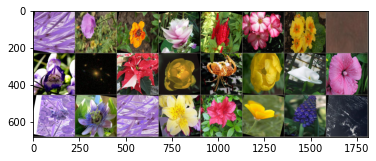

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

im_dimention = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.507, 0.487, 0.441])
    std = numpy.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

### Model and Training functions

In [9]:
model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class+1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
          
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

### Training

In [10]:
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2) 

Epoch 0/1
----------
train Loss: 0.3479 Acc: 0.9399
valid Loss: 0.0278 Acc: 0.9976

Epoch 1/1
----------
train Loss: 0.0112 Acc: 0.9981
valid Loss: 0.0234 Acc: 0.9976

Training complete in 21m 2s
Best val Acc: 0.997558


# Save Model

In [11]:
PATH = "./model_background.pt"
torch.save(model_ft.state_dict(), PATH)

'''
#Guideline for loading model in future 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.wide_resnet101_2(pretrained=False) 
        #We only need the structure to transfer parameters
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load(PATH2, map_location=device))
'''

'\n#Guideline for loading model in future \ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = models.wide_resnet101_2(pretrained=False) \n        #We only need the structure to transfer parameters\n        \nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, Num_class)\n\nmodel.load_state_dict(torch.load(PATH2, map_location=device))\n'

# Delete Downloaded Data

In [12]:
shutil.rmtree('./Background/')
shutil.rmtree('./flower_data/')